In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

data = pd.read_csv("online_shoppers_intention.csv")

In [145]:
def makeFreqGraph(df, col):
    # df (pd.Dataframe) -> dataset
    # col (str) -> column to make graph of
    if df[col].dtype == 'float64': #if float make a histogram to capture generic trend
        plt.hist(df[col])
    elif df[col].dtype == 'bool':
        df[col].value_counts().plot(kind='bar')
    else: #otherwise plot exact bars
        df = df.groupby(by=[col]).size().to_frame('count').reset_index()
        plt.bar(df[col], df['count'])
    plt.title("Frequencies of " + col)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

In [146]:
#Create features

data['Total_Duration'] = data['Administrative_Duration'] + data['Informational_Duration'] + data['ProductRelated_Duration']
data['Average_Time_Per_Page'] = data['Total_Duration'] / (data['Administrative'] + data['Informational'] + data['ProductRelated'] + 1e-6)


cat_cols = ['Month', 'OperatingSystems', 'Browser', 'Region',
                    'TrafficType', 'VisitorType', 'Weekend']

num_cols = ['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Total_Duration', 'Average_Time_Per_Page']



In [147]:
#drop duplicates
newdata = data.drop_duplicates().reset_index(drop=True)


categorical = newdata[cat_cols]
numerical = newdata[num_cols + ['Revenue']]

#Normalize numericals
scaler = MinMaxScaler()
numerical_normalized = numerical.copy()
numerical_normalized[num_cols] = pd.DataFrame(scaler.fit_transform(numerical_normalized[num_cols])) #normalize numericals, min-max here to keep values positive (0-1)

#One-hot categoricals
categorical_one_hot = categorical.astype(str)
categorical_one_hot = pd.get_dummies(categorical_one_hot).join(data['Revenue']) #onehot encode, join revenue after to avoid one_hot encoding class column

newdata = categorical_one_hot.join(numerical_normalized[num_cols])


In [148]:
print(newdata.isnull().any())

Month_Aug                False
Month_Dec                False
Month_Feb                False
Month_Jul                False
Month_June               False
                         ...  
ExitRates                False
PageValues               False
SpecialDay               False
Total_Duration           False
Average_Time_Per_Page    False
Length: 78, dtype: bool


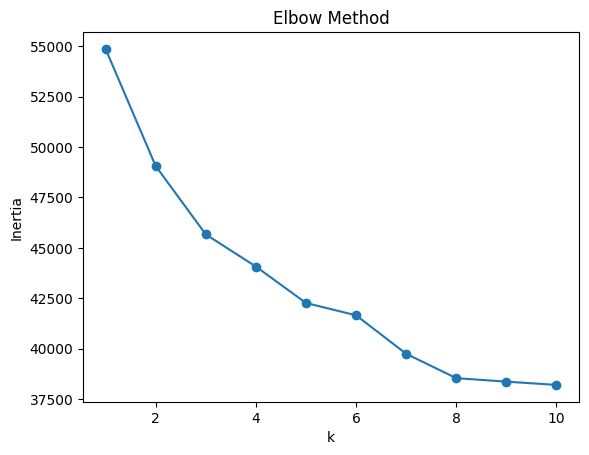

In [153]:
inertias = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(newdata)
    inertias.append(kmeans.inertia_)  # total within-cluster sum of squares

plt.plot(K_range, inertias, marker='o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()


In [154]:
from sklearn.metrics import silhouette_score

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(newdata)
    score = silhouette_score(newdata, labels)
    print(f"k={k}, silhouette={score:.3f}")


k=2, silhouette=0.139
k=3, silhouette=0.123
k=4, silhouette=0.115
k=5, silhouette=0.092
k=6, silhouette=0.079
k=7, silhouette=0.083
k=8, silhouette=0.079
k=9, silhouette=0.077
k=10, silhouette=0.073


In [150]:
correlation_matrix = data.corr(numeric_only=True)
high_corr = correlation_matrix[((correlation_matrix > 0.3) | (correlation_matrix < -0.3))& (correlation_matrix < 1)]
#print(high_corr.dropna(how='all').dropna(axis=1, how='all')) #all correlations above abs(0.7)
print(correlation_matrix)


                         Administrative  Administrative_Duration  \
Administrative                 1.000000                 0.601583   
Administrative_Duration        0.601583                 1.000000   
Informational                  0.376850                 0.302710   
Informational_Duration         0.255848                 0.238031   
ProductRelated                 0.431119                 0.289087   
ProductRelated_Duration        0.373939                 0.355422   
BounceRates                   -0.223563                -0.144170   
ExitRates                     -0.316483                -0.205798   
PageValues                     0.098990                 0.067608   
SpecialDay                    -0.094778                -0.073304   
OperatingSystems              -0.006347                -0.007343   
Browser                       -0.025035                -0.015392   
Region                        -0.005487                -0.005561   
TrafficType                   -0.033561         

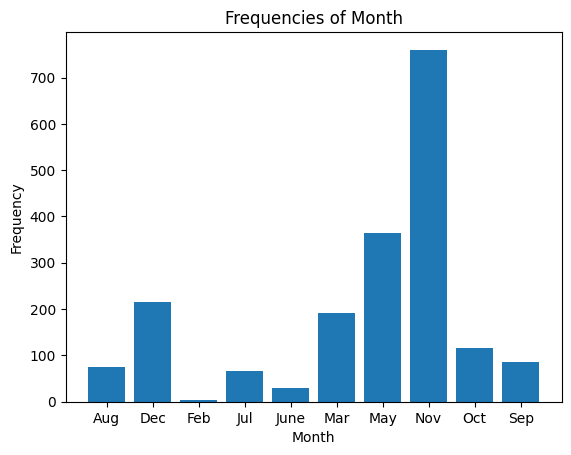

In [152]:
makeFreqGraph(data[data['Revenue'] == True], "Month")

In [109]:
print(newdata['Revenue'].value_counts(normalize=True)) #uncleaned data


Revenue
False    0.843671
True     0.156329
Name: proportion, dtype: float64
